In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import jax
import jax.numpy as jnp
import genjax
import rerun as rr

In [6]:
from tracking.model import model_factory, rerun_log_trace

In [7]:
PORT = 8812
rr.init("tracking")
rr.connect(addr=f'127.0.0.1:{PORT}')

In [18]:
model = model_factory(
    max_T = 10,
    width = 160,
    height = 120,
    pose_kernel_params = (1.0, 1.0),
    max_keypoint_mesh_width = 4,
    max_keypoint_mesh_height = 4,
    max_depth = 20.0
)

key = jax.random.PRNGKey(3)
trace = model.simulate(key, (10,))

In [19]:
rerun_log_trace(trace)

In [20]:
from tracking.sensor_model import lab_to_rgb

In [21]:
from b3d.utils import rgb_to_lab

In [22]:
for i in range(100):
    subkey, key = jax.random.split(key)
    rgb = jax.random.uniform(subkey, (3,))
    lab = rgb_to_lab(rgb)
    rgb2 = lab_to_rgb(lab)
    assert jnp.allclose(rgb, rgb2, atol=1e-3), f"{rgb} != {rgb2}"


In [23]:
for i in range(100):
    subkey, key = jax.random.split(key)
    lab = jax.random.uniform(subkey, (3,))
    lab = lab * jnp.array([100.0, 256.0, 256.0]) - jnp.array([0.0, 128.0, 128.0])
    rgb = lab_to_rgb(lab)
    lab2 = rgb_to_lab(rgb)
    assert jnp.allclose(lab, lab2, atol=4), f"{lab} != {lab2}"


AssertionError: [ 39.77536   86.08844  -78.404785] != [ 41.83797   79.807625 -75.01977 ]

In [ ]:
from tracking.sensor_model import gaussian_rgbd_sensor_model, laplace_rgbd_sensor_model, uniform_rgbd_sensor_model

In [25]:
img = trace.get_retval()[-1][0, ...]
rgb = img[..., :3]
depth = img[..., 3]

In [26]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, 20)
rendered_rgbs_gaussian, rendered_depths_gaussian = jax.vmap(
    gaussian_rgbd_sensor_model.sample, in_axes=(0, None, None, None, None)
)(
    keys, rgb, depth, 10.0, 1.0
)
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, 20)
rendered_rgbs_laplace, rendered_depths_laplace = jax.vmap(
    laplace_rgbd_sensor_model.sample, in_axes=(0, None, None, None, None)
)(
    keys, rgb, depth, 10.0, 1.0
)
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, 20)
rendered_rgbs_uniform, rendered_depths_uniform = jax.vmap(
    uniform_rgbd_sensor_model.sample, in_axes=(0, None, None, (None, None))
)(
    keys, rgb, depth, (0., 10.)

)

In [27]:
for i in range(20):
    rendered_rgb_g = rendered_rgbs_gaussian[i, ...]
    rendered_depth_g = rendered_depths_gaussian[i, ...]
    rendered_rgb_l = rendered_rgbs_laplace[i, ...]
    rendered_depth_l = rendered_depths_laplace[i, ...]
    rendered_rgb_u = rendered_rgbs_uniform[i, ...]
    rendered_depth_u = rendered_depths_uniform[i, ...]
    rr.set_time_sequence("img_sample", i)
    rr.log("/likelihood_experiment/rgb/original", rr.Image(rgb))
    rr.log("/likelihood_experiment/rgb/rendered_gaussian", rr.Image(rendered_rgb_g))
    rr.log("/likelihood_experiment/rgb/rendered_laplace", rr.Image(rendered_rgb_l))
    rr.log("/likelihood_experiment/rgb/rendered_uniform", rr.Image(rendered_rgb_u))
    rr.log("/likelihood_experiment/depth/original", rr.DepthImage(depth))
    rr.log("/likelihood_experiment/depth/rendered_gausian", rr.DepthImage(rendered_depth_g))
    rr.log("/likelihood_experiment/depth/rendered_laplace", rr.DepthImage(rendered_depth_l))
    rr.log("/likelihood_experiment/depth/rendered_uniform", rr.DepthImage(rendered_depth_u))

In [28]:
from tracking.sensor_model import mixture_rgbd_sensor_model
probs = [0.05, 0.8, 0.15]
args = [
    ((0., 10.),),
    (10.0, 1.0),
    (10.0, 1.0),
]


In [29]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, 20)
rendered_rgbs, rendered_depths = jax.vmap(
    mixture_rgbd_sensor_model.sample, in_axes=(
        0, None, None, None, None
    )
)(
    keys, probs, rgb, depth, args
)

TypeError: UniformRGBDSensorModel.sample() takes from 4 to 5 positional arguments but 6 were given

In [79]:
from tracking.mesh import Mesh

# sq = jax.vmap(
#     lambda x: Mesh.square_mesh([0., 0.], [x, x], jnp.array([0., 0., 0., 1.]))
# )(jnp.array([20., 30.]))

sq = Mesh.square_mesh(jnp.array([0.1, 0.]), jnp.array([20., 20.]), jnp.array([0., 0., 0., 1.]))

def render_mesh(mesh, pose):
    return mesh.to_image(
            jnp.zeros(3),
            64, 64,
            lambda rgbd: rgbd[-1],
            jnp.array([1., 1., 1., 10.])
        )

img = jax.vmap(render_mesh, in_axes=(None, 0))(sq, jnp.zeros((2, 3)))
img[0].shape

(64, 64, 4)

In [88]:
from tracking.mesh import Mesh

sq = Mesh.square_mesh(jnp.array([.1, 0.]), jnp.array([20., 20.]), jnp.array([0., 0., 0., 1.]))

img = sq.to_image(jnp.zeros(3), 22, 22,
        lambda rgbd: rgbd[-1],
        jnp.array([1., 1., 1., 10.])
    )

img[0].shape

(22, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


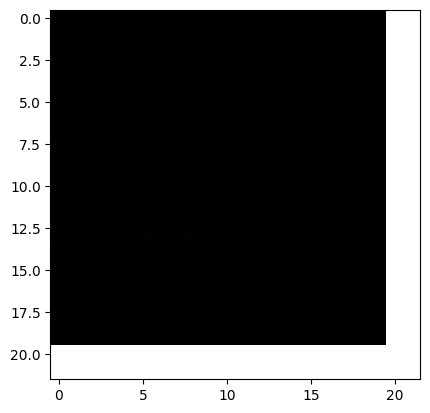

In [89]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [124]:
width, height = 20, 20
bottom_lefts = jnp.meshgrid(jnp.arange(width), jnp.arange(height))
bottom_lefts = jnp.stack(bottom_lefts, axis=-1).reshape(-1, 2)
bottom_lefts.shape

(400, 2)

In [131]:
from tracking.mesh import Mesh

In [132]:
width, height = 12, 15
attributes = jnp.ones((width, height, 4))

In [133]:
bottom_lefts = jnp.meshgrid(jnp.arange(width), jnp.arange(height))
bottom_lefts = jnp.stack(bottom_lefts, axis=-1).reshape(-1, 2)
widthheights = jnp.ones((width * height, 2))
attributes = attributes.reshape((-1, attributes.shape[-1]))


In [135]:
vmapped_mesh = jax.vmap(Mesh.square_mesh, in_axes=(0, 0, 0))(bottom_lefts, widthheights, attributes)


In [136]:
vertices = vmapped_mesh.vertices.reshape((-1, 2))
n_vertices_per_face = vmapped_mesh.vertices.shape[1]


In [143]:
vmapped_mesh.faces.shape

(180, 2, 3)

In [144]:
# Generate the base array
# arr = jnp.arange(vertices.shape[0])




Array([[  0,   1,   2],
       [  0,   2,   3],
       [  0,   1,   2],
       ...,
       [356, 358, 359],
       [356, 357, 358],
       [356, 358, 359]], dtype=int32)